In [24]:
%pip install --quiet pyreadstat statsmodels seaborn SyntheticControlMethods zstd pysyncon

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pyreadstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize, basinhopping
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.sandwich_covariance import cov_hc1
from sklearn.linear_model import LogisticRegression
import warnings
import pyreadstat

from pysyncon import Dataprep, Synth, PenalizedSynth
from pysyncon.utils import PlaceboTest



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:

dat = pd.read_stata('replication/CountryEPData.dta')
westminster = pd.read_csv('replication/westminster.csv')
dat_ip, _ = pyreadstat.read_dta('replication/CountryEPData_covIP.dta')

# match R script filtering: drop specific ccode values and the 2019 election
census_drop = {5, 6, 9, 12}
dat = dat[~dat['ccode'].isin(census_drop)]
dat = dat[dat['ep_election'] != 2019]

# merge covariates
merge_cols = ['ccode', 'year', 'ep_election']
dat = dat.merge(dat_ip, on=merge_cols, how='left')

# keep the same columns as the R setup
cols = [
    'rr_votes', 'E_eubadIP', 'E_NatDem_satisfiedIP', 'unempIP', 'opencIP',
    'S_uegenIP', 'rightgovIP', 'ch_imp_fns', 'eu_pos_meanIP', 'migr_inflIP',
    'ccode', 'country', 'ep_election', 'year'
]
dat = dat[cols]

# donor pool: all countries except the treated unit
controls = sorted(c for c in dat['country'].unique() if c != 'United Kingdom')

# pre-treatment years exactly as in SCM_est.R
pre_years = [1979, 1999]
# drop nas for rr votes
dat = dat.dropna(subset=['rr_votes'])

# special predictors mirror the R times_pred matrix (explicit years)
special_predictors = [
    ('migr_inflIP', pre_years, 'mean'),
    ('rr_votes', pre_years, 'mean'),
    ('E_eubadIP', pre_years, 'mean'),
    ('E_NatDem_satisfiedIP', pre_years, 'mean'),
    ('unempIP', pre_years, 'mean'),
    ('opencIP', pre_years, 'mean'),
    ('S_uegenIP', pre_years, 'mean'),
    ('rightgovIP', pre_years, 'mean'),
    ('ch_imp_fns', pre_years, 'mean'),
    ('eu_pos_meanIP', pre_years, 'mean'),
]

# build dataprep object aligned with SCM_est.R
dataprep = Dataprep(
    foo=dat,
    predictors=[
        'rr_votes', 'E_eubadIP', 'E_NatDem_satisfiedIP', 'unempIP', 'opencIP',
        'S_uegenIP', 'rightgovIP', 'ch_imp_fns', 'eu_pos_meanIP', 'migr_inflIP'
    ],
    predictors_op='mean',
    time_predictors_prior=pre_years,
    special_predictors=special_predictors,
    controls_identifier=controls,
    dependent='rr_votes',
    unit_variable='country',
    time_variable='ep_election',
    treatment_identifier='United Kingdom',
    time_optimize_ssr=pre_years,
)


In [39]:
synth = Synth()
synth.fit(dataprep, optim_method="Nelder-Mead", optim_initial="equal")
synth.weights()

Belgium        0.000
Denmark        0.875
Germany        0.000
Greece         0.000
Ireland        0.000
Italy          0.125
Netherlands    0.000
Name: weights, dtype: float64

In [40]:
pen = PenalizedSynth()
pen.fit(dataprep, lambda_=1)
pen.weights()

Belgium        0.0
Denmark        1.0
Germany        0.0
Greece         0.0
Ireland        0.0
Italy          0.0
Netherlands    0.0
Name: weights, dtype: float64

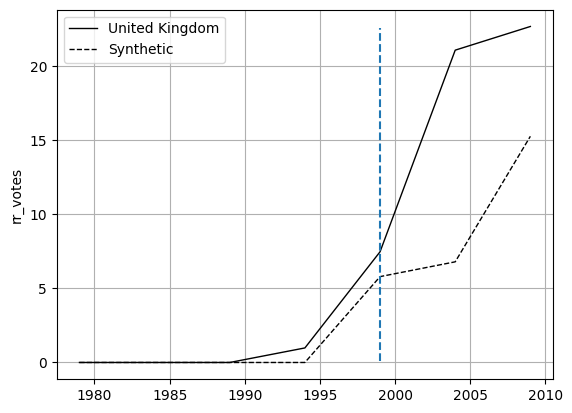

In [41]:
pen.path_plot(time_period=range(1979, 2010), treatment_time=1999)

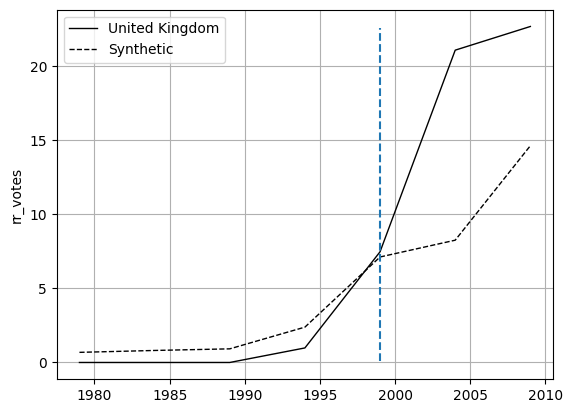

In [42]:
synth.path_plot(time_period=range(1979, 2010), treatment_time=1999)

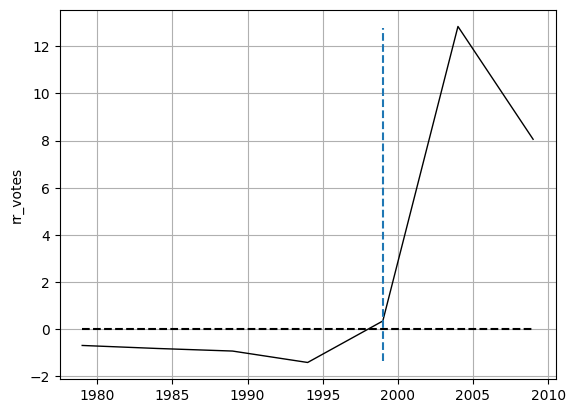

In [43]:
# gaps plot
synth.gaps_plot(time_period=range(1979, 2010), treatment_time=1999)

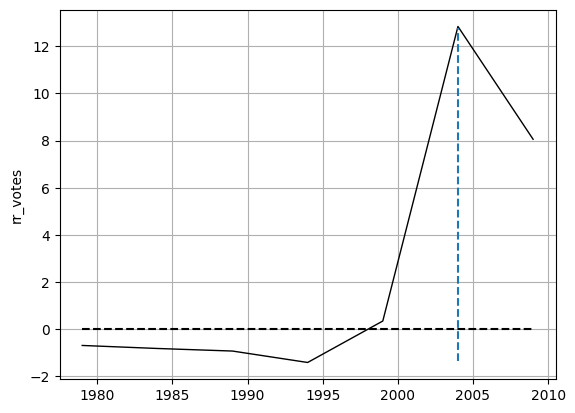

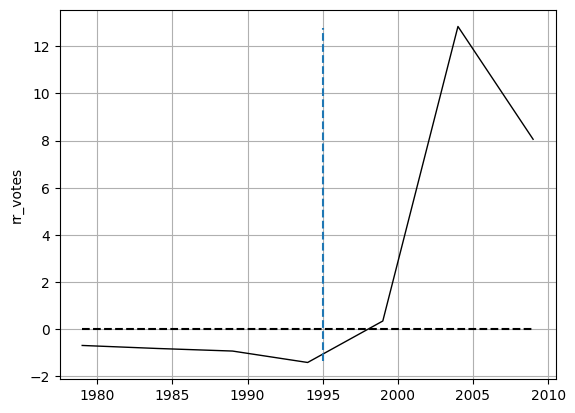

In [46]:
# time placebo
synth.gaps_plot(time_period=range(1979, 2010), treatment_time=2004)
synth.gaps_plot(time_period=range(1979, 2010), treatment_time=1995)

In [47]:
placebo_test = PlaceboTest()
placebo_test.fit(dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
    )

(1/7) Completed placebo test for Greece.
(2/7) Completed placebo test for Germany.
(3/7) Completed placebo test for Denmark.
(4/7) Completed placebo test for Belgium.
(5/7) Completed placebo test for Italy.
(6/7) Completed placebo test for Ireland.
(7/7) Completed placebo test for Netherlands.
Calculating treated unit gaps.
Done.


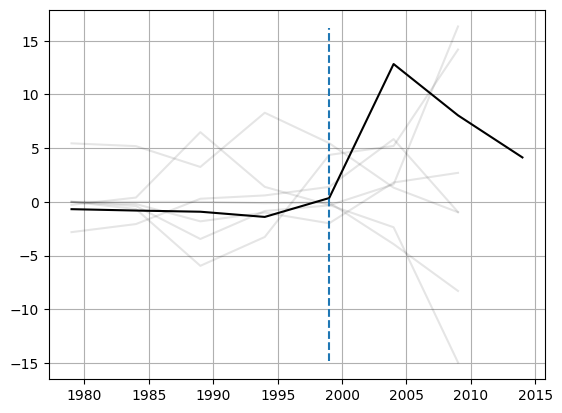

In [48]:
# plot placebo
placebo_test.gaps_plot(time_period=range(1979, 2010), treatment_time=1999)

In [22]:
synth.summary()

,V,treated,synthetic,sample mean
rr_votes,0.050,0.246,0.000,2.401
E_eubadIP,0.050,0.284,0.196,0.098
E_NatDem_satisfiedIP,0.050,0.546,0.638,0.551
unempIP,0.050,7.975,8.332,8.111
opencIP,0.050,51.171,74.852,74.678
S_uegenIP,0.050,9.450,9.503,9.271
rightgovIP,0.050,0.750,0.463,0.393
ch_imp_fns,0.050,0.549,0.773,0.724
eu_pos_meanIP,0.050,5.107,5.614,6.047
migr_inflIP,0.050,220066.667,32062.472,180365.283
